In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel(r"C:\Users\Yash\Desktop\ExcelR Project\Codes\RWTCm.xls")
print(df.shape, df.head())

(456, 2)         Date   COSP
0 1986-01-15  22.93
1 1986-02-15  15.46
2 1986-03-15  12.61
3 1986-04-15  12.84
4 1986-05-15  15.38


In [3]:
df.index.freq = 'MS'
df.set_index('Date',inplace=True)

In [4]:
df.head()

,COSP
Date,
1986-01-15,22.93
1986-02-15,15.46
1986-03-15,12.61
1986-04-15,12.84
1986-05-15,15.38


<Axes: xlabel='Date'>

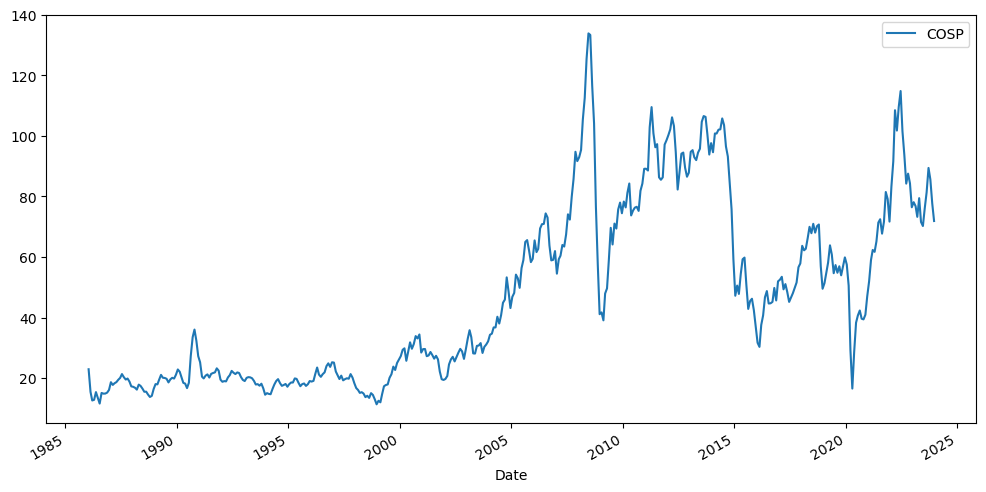

In [5]:
df.plot(figsize=(12,6))

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

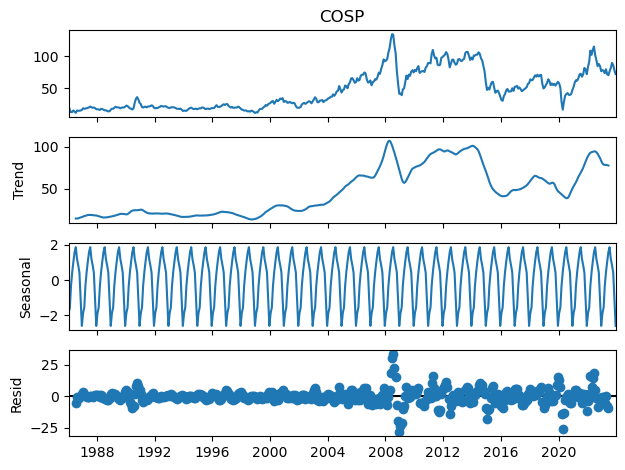

In [7]:
results = seasonal_decompose(df['COSP'],period=12)
results.plot();

In [8]:
len(df)

456

In [9]:
train = df.iloc[:444]
test = df.iloc[444:]

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [11]:
df.head(),df.tail()

(             COSP
 Date             
 1986-01-15  22.93
 1986-02-15  15.46
 1986-03-15  12.61
 1986-04-15  12.84
 1986-05-15  15.38,
              COSP
 Date             
 2023-08-15  81.39
 2023-09-15  89.43
 2023-10-15  85.64
 2023-11-15  77.69
 2023-12-15  71.90)

In [12]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [13]:
scaled_train[:10]

array([[0.09450747],
       [0.03354281],
       [0.0102832 ],
       [0.01216029],
       [0.0328899 ],
       [0.01697543],
       [0.0019587 ],
       [0.03060475],
       [0.02872766],
       [0.0289725 ]])

In [14]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [15]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [16]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.09450747 0.03354281 0.0102832 ]
Predict this y: 
 [[0.01216029]]


In [17]:
X.shape

(1, 3, 1)

In [18]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [19]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [20]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50

432/432 [==============================] - 4s 5ms/step - loss: 0.0180
Epoch 2/50
432/432 [==============================] - 2s 5ms/step - loss: 0.0068
Epoch 3/50
432/432 [==============================] - 2s 5ms/step - loss: 0.0053
Epoch 4/50
432/432 [==============================] - 2s 5ms/step - loss: 0.0042
Epoch 5/50
432/432 [==============================] - 2s 5ms/step - loss: 0.0034
Epoch 6/50
432/432 [==============================] - 2s 5ms/step - loss: 0.0025
Epoch 7/50
432/432 [==============================] - 2s 5ms/step - loss: 0.0026
Epoch 8/50
432/432 [==============================] - 2s 5ms/step - loss: 0.0025
Epoch 9/50
432/432 [==============================] - 2s 5ms/step - loss: 0.0020
Epoch 10/50
432/432 [==============================] - 2s 5ms/step - loss: 0.0021
Epoch 11/50
432/432 [==============================] - 2s 5ms/step - loss: 0.0020
Epoch 12/50
432/432 [==============================] - 2s 5ms/step - loss: 0.0016
Epoch 13/50
432/432 [===

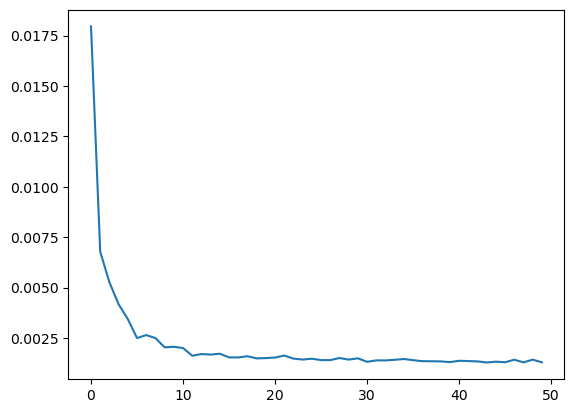

In [23]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [24]:
last_train_batch = scaled_train[-12:]

In [25]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [26]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 209ms/step


array([[0.48019198]], dtype=float32)

In [27]:
scaled_test[0]

array([0.54492777])

In [28]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]

    # append the prediction into the array
    test_predictions.append(current_pred)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 26ms/step


In [29]:
test_predictions

[array([0.48019198], dtype=float32),
 array([0.43946007], dtype=float32),
 array([0.40880033], dtype=float32),
 array([0.3857928], dtype=float32),
 array([0.3680145], dtype=float32),
 array([0.35463902], dtype=float32),
 array([0.34440845], dtype=float32),
 array([0.33607742], dtype=float32),
 array([0.32936832], dtype=float32),
 array([0.32408366], dtype=float32),
 array([0.3196014], dtype=float32),
 array([0.3156064], dtype=float32)]

In [30]:
test.head()

,COSP
Date,
2023-01-15,78.12
2023-02-15,76.83
2023-03-15,73.28
2023-04-15,79.45
2023-05-15,71.58


In [31]:
true_predictions = scaler.inverse_transform(test_predictions)

In [32]:
test['Predictions'] = true_predictions

C:\Users\Yash\AppData\Local\Temp\ipykernel_5876\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<Axes: xlabel='Date'>

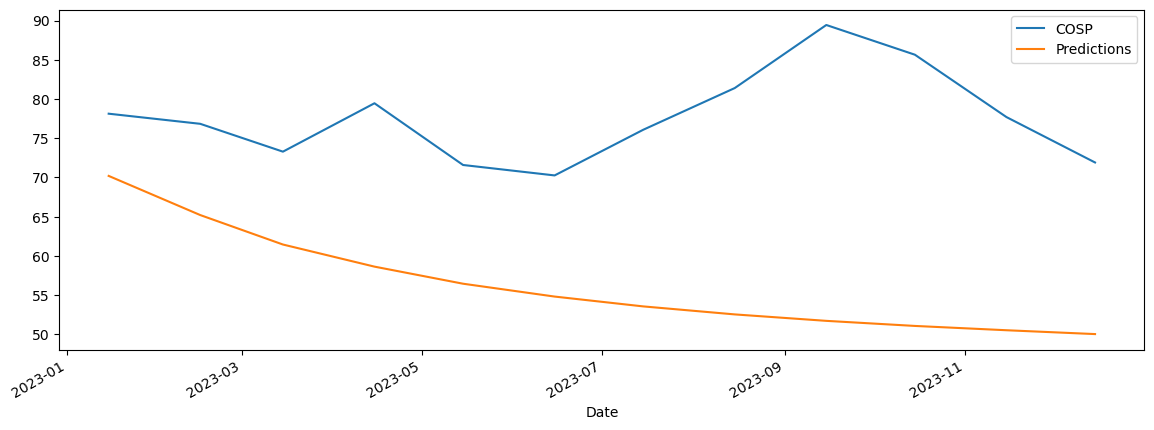

In [33]:
test.plot(figsize=(14,5))

In [34]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['COSP'],test['Predictions']))
print(rmse)

23.123205599872932
